In [12]:
import torch
import joblib
import pandas as pd
import torch.nn as nn
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #其實沒啥用，但我懶得改了
print("Using device:", device)

Using device: cuda


In [13]:
#再架設一次環境
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [14]:
# 1.載入模型
scaler = joblib.load("ann_scaler.pkl")
#會有警告，內容為檔案來源有風險，問題不大
model = ANN()
model.load_state_dict(torch.load("ann_model.pth"))
model.eval()   # 設成 inference 模式

C:\Users\Desmond\anaconda3\envs\torch-cu121\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Desmond\AppData\Local\Temp\ipykernel_17008\2447815532.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects

ANN(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [15]:
# 2.讀取測試用資料
df_test = pd.read_csv("test_data.csv")

print("Total test rows:", len(df_test))
print(df_test.columns)
# 3. 準備 ANN 輸入
X_test = df_test[['a', 'm', 'V0', 'n', "x'"]].values

# 使用訓練時的 scaler（不能重新 fit）
X_test_scaled = scaler.transform(X_test)

# 轉成 tensor
X_test_tensor = torch.tensor(
    X_test_scaled,
    dtype=torch.float32
)
y_true = df_test['psi_raw'].values
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy().ravel()

Total test rows: 4720
Index(['a', 'm', 'V0', 'n', 'x', 'x'', 'psi_raw', 'psi_norm'], dtype='object')


MSE = 3.249029e-03
MAE = 1.678887e-02


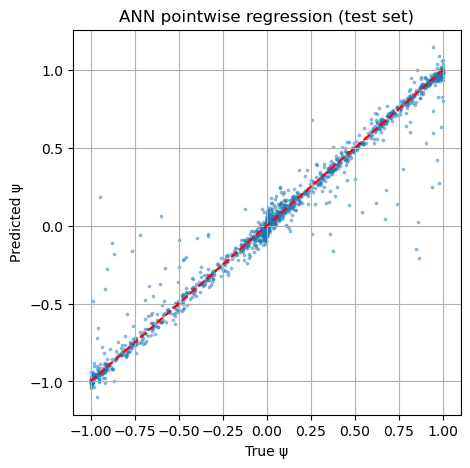

In [16]:
#分析1，整體散點對於計算值之誤差
mse = np.mean((y_true - y_pred)**2)
mae = np.mean(np.abs(y_true - y_pred))

print(f"MSE = {mse:.6e}")
print(f"MAE = {mae:.6e}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=3, alpha=0.4)
lims = [y_true.min(), y_true.max()]
plt.plot(lims, lims, 'r--')     #紅線為最理想狀態，測試與模型預測完全疊合的情況
plt.xlabel("True ψ")
plt.ylabel("Predicted ψ")
plt.title("ANN pointwise regression (test set)")
plt.grid(True)
plt.show()

In [17]:
r, p = pearsonr(y_true, y_pred)

print(f"Pearson r = {r:.6f}")

Pearson r = 0.984038


Error mean: -0.0001359302085753353
Error std : 0.05700009610166686


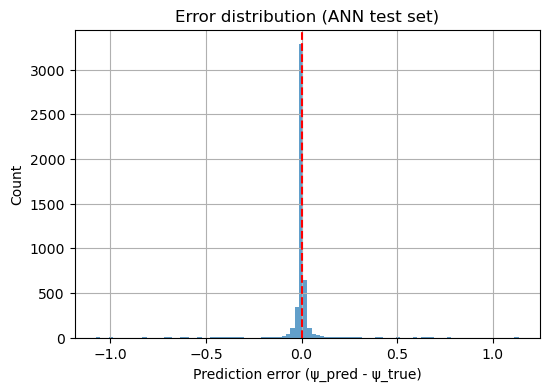

In [18]:
#分析2，誤差值直方圖，計算其標準差和平均，作為整體分析
error = y_pred - y_true

print("Error mean:", np.mean(error))
print("Error std :", np.std(error))

plt.figure(figsize=(6,4))
plt.hist(error, bins=100, alpha=0.7)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Prediction error (ψ_pred - ψ_true)")
plt.ylabel("Count")
plt.title("Error distribution (ANN test set)")
plt.grid(True)
plt.show()

Selected sample:
a=1.100e-08, m=1.100e-30, V0=4.806e-21, n=2
Number of ANN points: 1


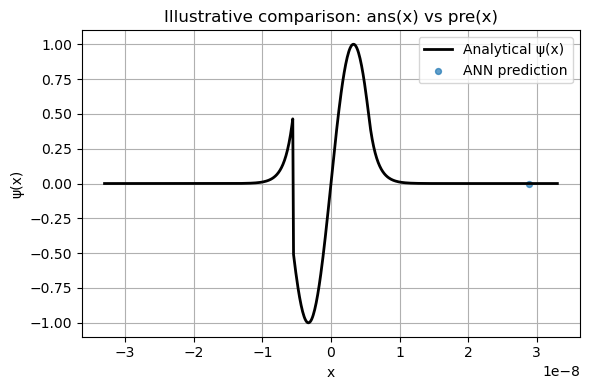

x of ANN point: [2.8908e-08]
Is inside well: [False]


In [56]:
#分析3，固定環境參數進行分析，判斷散點與公式解的差距，作為細節分析
#從 test_data 隨機選一個a,m,v,n，模型會預測出一個點。
#從data.py叫出公式(求解器)，解a,m,v,n的波函數。比對模型預測之點與公式曲線的差距
from data import find_bound_states, compute_wavefunction

df_candidate = df_test[df_test["n"] < 3]
sample = df_candidate.sample(n=1).iloc[0]

a0  = sample["a"]
m0  = sample["m"]
V00 = sample["V0"]
n0  = int(sample["n"])

print("Selected sample:")
print(f"a={a0:.3e}, m={m0:.3e}, V0={V00:.3e}, n={n0}")

# -------------------------
# 3. Collect ALL test points with same (a,m,V0,n)
# -------------------------
df_n = df_test[
    (df_test["a"]  == a0) &
    (df_test["m"]  == m0) &
    (df_test["V0"] == V00) &
    (df_test["n"]  == n0)
].sort_values("x")

print("Number of ANN points:", len(df_n))

# -------------------------
# 4. Analytical solution (full curve)
# -------------------------
states = find_bound_states(a0, m0, V00)
parity, k, E = states[n0 - 1]

xs_exact, _, psi_exact, _ = compute_wavefunction(
    a0, m0, V00,
    parity, k, E,
    num_points=600
)

# -------------------------
# 5. ANN prediction (ONLY on test_data x)
# -------------------------
xs_ann = df_n["x"].values

X_ann = np.column_stack([
    np.full_like(xs_ann, a0),
    np.full_like(xs_ann, m0),
    np.full_like(xs_ann, V00),
    np.full_like(xs_ann, n0),
    xs_ann
])

X_ann_scaled = scaler.transform(X_ann)

X_tensor = torch.tensor(
    X_ann_scaled,
    dtype=torch.float32,
)

with torch.no_grad():
    psi_pred = model(X_tensor).cpu().numpy().ravel()
    # --- normalize ANN prediction to psi_norm ---
    dx = xs_ann[1] - xs_ann[0] if len(xs_ann) > 1 else (xs_exact[1] - xs_exact[0])
    norm_pred = np.sqrt(np.sum(psi_pred**2) * dx)
    
    if norm_pred > 0:
        psi_pred_norm = psi_pred / norm_pred
    else:
        psi_pred_norm = psi_pred.copy()

# -------------------------
# 6. Plot (matches your sketch)
# -------------------------
plt.figure(figsize=(6, 4))

# ans(x): full analytical curve
plt.plot(
    xs_exact,
    psi_exact,
    color="black",
    linewidth=2,
    label="Analytical ψ(x)"
)

# pre(x): discrete ANN points (NO extrapolation)
plt.scatter(
    xs_ann,
    psi_pred,
    s=18,
    alpha=0.7,
    color="tab:blue",
    label="ANN prediction"
)

plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.title("Illustrative comparison: ans(x) vs pre(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("x of ANN point:", xs_ann)
print("Is inside well:", np.abs(xs_ann) <= a0/2)